Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU configured for TensorFlow
Technical indicators took 21.14 seconds
Extract and create required features - Done
Machine learning models took 2.35 seconds
1540/1540 [==============================] - 3s 2ms/step
[[0.9983261 ]
 [0.9924499 ]
 [0.9987471 ]
 ...
 [0.99482226]
 [0.01400205]
 [0.00170515]]


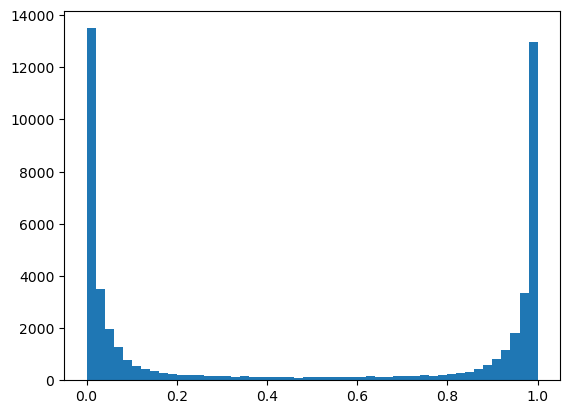

794/794 [==============================] - 1s 2ms/step
DNN model took 39.32 seconds
Train DNN models - Done


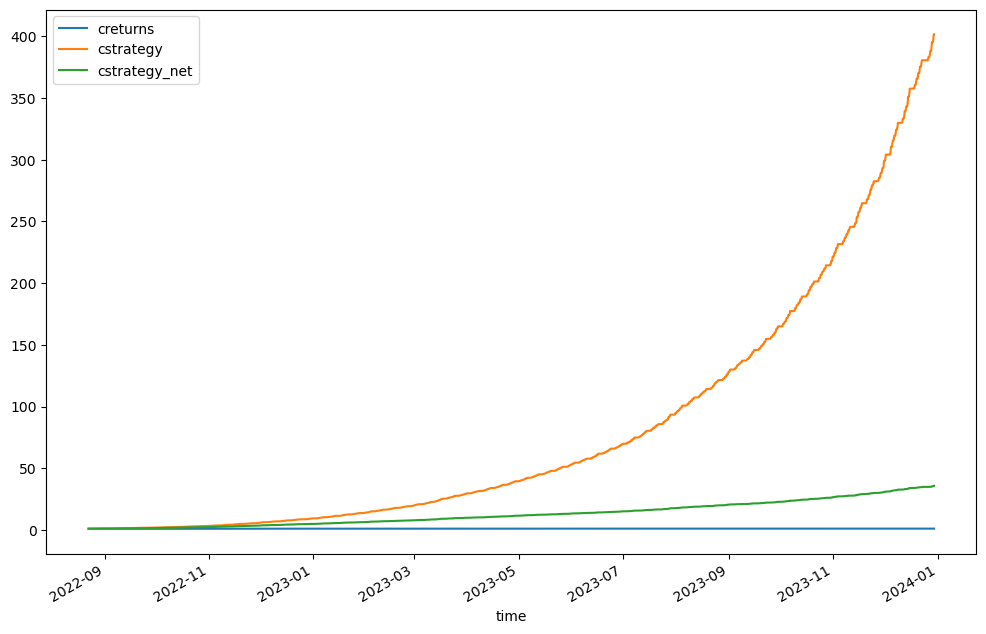

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.utils import dropna
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from DNNModelWithML import create_model, cw, set_seeds
import time

warnings.simplefilter(action='ignore', category=FutureWarning)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for device in tf.config.list_physical_devices('GPU'):
    print(device)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configured for TensorFlow")
    except RuntimeError as e:
        print(e)

def preprocessing(name):
    df = pd.read_csv(name, delimiter="\t")
    df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
    df.drop(['<DATE>', '<TIME>'], axis=1, inplace=True)
    df.set_index('<DATETIME>', inplace=True)
    df = df.iloc[:, :-2]
    df.columns = ["open", "high", "low", "EUR_USD", "volume"]
    df.index.name = "time"
    return df

start_time = time.time()
df = preprocessing("datasets/EURUSD_M20_202001020600_202312292340.csv")
df["returns"] = np.log(df["EUR_USD"] / df["EUR_USD"].shift())
df["dir"] = np.where(df["returns"] > 0, 1, 0)
df = add_all_ta_features(df, open="open", high="high", low="low", close="EUR_USD", volume="volume", fillna=True)
tech_indicators_time = time.time() - start_time
print(f"Technical indicators took {tech_indicators_time:.2f} seconds")

features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_rsi', 'trend_macd', 
            'volatility_bbm', 'volatility_bbl', 'momentum_stoch', 'volatility_atr', 
            'trend_ichimoku_a', 'trend_psar_up']
df.dropna(inplace=True)
lags = 5
lagged_features = pd.concat([df[f].shift(lag).rename(f"{f}_lag_{lag}") for f in features for lag in range(1, lags + 1)], axis=1)
df = pd.concat([df, lagged_features], axis=1)
df.dropna(inplace=True)

ptc = 0.00020  
df["trading_cost"] = ptc * df["EUR_USD"]

split = int(len(df) * 0.66)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

print("Extract and create required features - Done")

X = train[lagged_features.columns].copy()
y = train["dir"].copy()
X_test = test[lagged_features.columns].copy()
y_test = test["dir"].copy()

X.loc[:, "trading_cost"] = train["trading_cost"]
X_test.loc[:, "trading_cost"] = test["trading_cost"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()
models = [
    
    LogisticRegression(max_iter=1000)
]

for i, model in enumerate(models):
    model.fit(X_scaled, y)
    train[f"model_{i}_pred"] = model.predict_proba(X_scaled)[:, 1]
    test[f"model_{i}_pred"] = model.predict_proba(X_test_scaled)[:, 1]

ml_models_time = time.time() - start_time
print(f"Machine learning models took {ml_models_time:.2f} seconds")

cols = list(lagged_features.columns) + ["trading_cost"] + [f"model_{i}_pred" for i in range(len(models))]

mu, std = train.mean(), train.std()
train_s = (train - mu) / std
test_s = (test - mu) / std

start_time = time.time()
set_seeds(100)
model = create_model(hl=3, hu=50, dropout=True, input_dim=len(cols), regularize=True, reg=l2(0.001))

model.fit(x=train_s[cols], y=train["dir"], epochs=50, batch_size=1024, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train))
model.evaluate(train_s[cols], train["dir"])
pred = model.predict(train_s[cols])
print(pred)
pred = np.clip(pred, 0, 1)

plt.hist(pred, bins=50)
plt.show()

test_s = (test - mu) / std
model.evaluate(test_s[cols], test["dir"])
pred = model.predict(test_s[cols])
pred = np.clip(pred, 0, 1)  
test["proba"] = pred
dnn_time = time.time() - start_time
print(f"DNN model took {dnn_time:.2f} seconds")

print("Train DNN models - Done")


test["position"] = 0  

for i in range(1, len(test)):
    current_proba = test["proba"].iloc[i]

    if current_proba > 0.53: 
        test.loc[test.index[i], "position"] = 1
    elif current_proba < 0.47:  
        test.loc[test.index[i], "position"] = -1
    else:
        test.loc[test.index[i], "position"] = test["position"].iloc[i - 1]  

test.index = test.index.tz_localize("UTC")
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position)
test["position"] = test.position.ffill().fillna(0)
test["strategy"] = test["position"] * test["returns"]

test["trades"] = test.position.diff().abs()
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)
test["cstrategy_net"] = (test["strategy"] - test["trades"] * ptc).cumsum().apply(np.exp)
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize=(12, 8))
plt.show()
model.save("DNN_model.keras")

import pickle
params = {"mu": mu, "std": std}
pickle.dump(params, open("params.pkl", "wb"))
